## Imports and Load + Split Data

In [2]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import os


train_dataset = datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([      
                transforms.ToTensor(),           
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

def train_valid_split(train_dataset, fraction):
    np.random.random(148)
    
    all_indices = list(range(len(train_dataset)))
    np.random.shuffle(all_indices)
    all_indices = all_indices[:int(len(all_indices)*fraction)]
    
    digits = {}
    for i in all_indices:
        label = train_dataset[i][1]
        if label in digits:
            digits[label].append(i)
        else:
            digits[label] = [i]
    
    subset_indices_train = []
    subset_indices_valid = []
    
    for digit in digits:
        indices = digits[digit]
        total = len(indices)
        np.random.shuffle(indices)
        subset_indices_valid.extend(indices[:int(0.15*total)])
        subset_indices_train.extend(indices[int(0.15*total):int(total)])

    assert(len(subset_indices_train) + len(subset_indices_valid) == len(all_indices))
    return subset_indices_train, subset_indices_valid


class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.norm = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.15)
        self.dropout2 = nn.Dropout2d(0.15)
        self.fc1 = nn.Linear(1600, 64)
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output
    
    
def train(model, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()  
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()               
        output = model(data)              
        loss = F.nll_loss(output, target) 
        losses.append(loss.item())
        loss.backward()                  
        optimizer.step()                   
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item()))     
    return np.average(losses)


def test(model, test_loader):
    model.eval()    
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad(): 
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)
    test_loss /= test_num
    print('\nAccuracy: {}/{} ({:.0f}%)\n'.format( correct, test_num, 100. * correct / test_num))
    return (100. * correct / test_num)
    

In [3]:
subsets = [0.0625, 0.125, 0.25, 0.5, 1]

training_losses = []
valid_losses = []
training_errors = []
test_errors = []

for fraction in subsets:
    subset_indices_train, subset_indices_valid = train_valid_split(train_dataset, fraction)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64,
        sampler=SubsetRandomSampler(subset_indices_train)
    )
    val_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64,
        sampler=SubsetRandomSampler(subset_indices_valid)
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=True)
    
    model = Net()
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    train_loss = []
    valid_loss = []
    epochs = 5
    for epoch in range(1, epochs + 1):
        train_loss.append(train(model, train_loader, optimizer, epoch))
        valid_loss.append(test(model, val_loader))
        scheduler.step() 

    print("Training Set ({} Subset):".format(str(fraction)))
    train_error = test(model, train_loader)
    print("Test Set ({} Subset):".format(str(fraction)))
    test_error = test(model, test_loader)
    
    training_errors.append(train_error)
    test_errors.append(test_error)
    training_losses.append(train_loss)
    valid_losses.append(valid_loss)

    torch.save(model.state_dict(), "best_MNIST_Net_{}.pt".format(str(fraction)))

Train Epoch: 1 [0/3192 (0%)]	Loss: 2.323927
Train Epoch: 1 [640/3192 (20%)]	Loss: 1.533545
Train Epoch: 1 [1280/3192 (40%)]	Loss: 0.717420
Train Epoch: 1 [1920/3192 (60%)]	Loss: 0.506871
Train Epoch: 1 [2560/3192 (80%)]	Loss: 0.289916

Accuracy: 526/558 (94%)

Train Epoch: 2 [0/3192 (0%)]	Loss: 0.165952
Train Epoch: 2 [640/3192 (20%)]	Loss: 0.183172
Train Epoch: 2 [1280/3192 (40%)]	Loss: 0.370768
Train Epoch: 2 [1920/3192 (60%)]	Loss: 0.212875
Train Epoch: 2 [2560/3192 (80%)]	Loss: 0.137853

Accuracy: 525/558 (94%)

Train Epoch: 3 [0/3192 (0%)]	Loss: 0.086240
Train Epoch: 3 [640/3192 (20%)]	Loss: 0.094332
Train Epoch: 3 [1280/3192 (40%)]	Loss: 0.098435
Train Epoch: 3 [1920/3192 (60%)]	Loss: 0.118852
Train Epoch: 3 [2560/3192 (80%)]	Loss: 0.126426

Accuracy: 538/558 (96%)

Train Epoch: 4 [0/3192 (0%)]	Loss: 0.059022
Train Epoch: 4 [640/3192 (20%)]	Loss: 0.034134
Train Epoch: 4 [1280/3192 (40%)]	Loss: 0.013709
Train Epoch: 4 [1920/3192 (60%)]	Loss: 0.043976
Train Epoch: 4 [2560/3192 (80%

Train Epoch: 5 [1920/12754 (15%)]	Loss: 0.042932
Train Epoch: 5 [2560/12754 (20%)]	Loss: 0.008047
Train Epoch: 5 [3200/12754 (25%)]	Loss: 0.073221
Train Epoch: 5 [3840/12754 (30%)]	Loss: 0.007362
Train Epoch: 5 [4480/12754 (35%)]	Loss: 0.010274
Train Epoch: 5 [5120/12754 (40%)]	Loss: 0.003046
Train Epoch: 5 [5760/12754 (45%)]	Loss: 0.007613
Train Epoch: 5 [6400/12754 (50%)]	Loss: 0.002908
Train Epoch: 5 [7040/12754 (55%)]	Loss: 0.018687
Train Epoch: 5 [7680/12754 (60%)]	Loss: 0.008861
Train Epoch: 5 [8320/12754 (65%)]	Loss: 0.009768
Train Epoch: 5 [8960/12754 (70%)]	Loss: 0.003517
Train Epoch: 5 [9600/12754 (75%)]	Loss: 0.027097
Train Epoch: 5 [10240/12754 (80%)]	Loss: 0.017046
Train Epoch: 5 [10880/12754 (85%)]	Loss: 0.028635
Train Epoch: 5 [11520/12754 (90%)]	Loss: 0.002286
Train Epoch: 5 [12160/12754 (95%)]	Loss: 0.009921

Accuracy: 2212/2246 (98%)

Training Set (0.25 Subset):

Accuracy: 12704/12754 (100%)

Test Set (0.25 Subset):

Accuracy: 9842/10000 (98%)

Train Epoch: 1 [0/25505

Train Epoch: 4 [16000/25505 (63%)]	Loss: 0.000687
Train Epoch: 4 [16640/25505 (65%)]	Loss: 0.000708
Train Epoch: 4 [17280/25505 (68%)]	Loss: 0.004551
Train Epoch: 4 [17920/25505 (70%)]	Loss: 0.001925
Train Epoch: 4 [18560/25505 (73%)]	Loss: 0.005476
Train Epoch: 4 [19200/25505 (75%)]	Loss: 0.000860
Train Epoch: 4 [19840/25505 (78%)]	Loss: 0.000604
Train Epoch: 4 [20480/25505 (80%)]	Loss: 0.051644
Train Epoch: 4 [21120/25505 (83%)]	Loss: 0.085564
Train Epoch: 4 [21760/25505 (85%)]	Loss: 0.000527
Train Epoch: 4 [22400/25505 (88%)]	Loss: 0.011759
Train Epoch: 4 [23040/25505 (90%)]	Loss: 0.037251
Train Epoch: 4 [23680/25505 (93%)]	Loss: 0.008252
Train Epoch: 4 [24320/25505 (95%)]	Loss: 0.009127
Train Epoch: 4 [24960/25505 (98%)]	Loss: 0.138204

Accuracy: 4441/4495 (99%)

Train Epoch: 5 [0/25505 (0%)]	Loss: 0.005307
Train Epoch: 5 [640/25505 (3%)]	Loss: 0.000783
Train Epoch: 5 [1280/25505 (5%)]	Loss: 0.004699
Train Epoch: 5 [1920/25505 (8%)]	Loss: 0.014400
Train Epoch: 5 [2560/25505 (10%)]	

Train Epoch: 2 [17280/51005 (34%)]	Loss: 0.017924
Train Epoch: 2 [17920/51005 (35%)]	Loss: 0.012809
Train Epoch: 2 [18560/51005 (36%)]	Loss: 0.053179
Train Epoch: 2 [19200/51005 (38%)]	Loss: 0.008463
Train Epoch: 2 [19840/51005 (39%)]	Loss: 0.093633
Train Epoch: 2 [20480/51005 (40%)]	Loss: 0.087926
Train Epoch: 2 [21120/51005 (41%)]	Loss: 0.036048
Train Epoch: 2 [21760/51005 (43%)]	Loss: 0.005182
Train Epoch: 2 [22400/51005 (44%)]	Loss: 0.073555
Train Epoch: 2 [23040/51005 (45%)]	Loss: 0.040741
Train Epoch: 2 [23680/51005 (46%)]	Loss: 0.003862
Train Epoch: 2 [24320/51005 (48%)]	Loss: 0.074093
Train Epoch: 2 [24960/51005 (49%)]	Loss: 0.012367
Train Epoch: 2 [25600/51005 (50%)]	Loss: 0.007210
Train Epoch: 2 [26240/51005 (51%)]	Loss: 0.036015
Train Epoch: 2 [26880/51005 (53%)]	Loss: 0.063972
Train Epoch: 2 [27520/51005 (54%)]	Loss: 0.040846
Train Epoch: 2 [28160/51005 (55%)]	Loss: 0.302554
Train Epoch: 2 [28800/51005 (56%)]	Loss: 0.016676
Train Epoch: 2 [29440/51005 (58%)]	Loss: 0.045967


Train Epoch: 4 [19840/51005 (39%)]	Loss: 0.002982
Train Epoch: 4 [20480/51005 (40%)]	Loss: 0.068850
Train Epoch: 4 [21120/51005 (41%)]	Loss: 0.052400
Train Epoch: 4 [21760/51005 (43%)]	Loss: 0.024690
Train Epoch: 4 [22400/51005 (44%)]	Loss: 0.001547
Train Epoch: 4 [23040/51005 (45%)]	Loss: 0.059049
Train Epoch: 4 [23680/51005 (46%)]	Loss: 0.010651
Train Epoch: 4 [24320/51005 (48%)]	Loss: 0.123506
Train Epoch: 4 [24960/51005 (49%)]	Loss: 0.090056
Train Epoch: 4 [25600/51005 (50%)]	Loss: 0.011373
Train Epoch: 4 [26240/51005 (51%)]	Loss: 0.006037
Train Epoch: 4 [26880/51005 (53%)]	Loss: 0.015710
Train Epoch: 4 [27520/51005 (54%)]	Loss: 0.010152
Train Epoch: 4 [28160/51005 (55%)]	Loss: 0.001200
Train Epoch: 4 [28800/51005 (56%)]	Loss: 0.062949
Train Epoch: 4 [29440/51005 (58%)]	Loss: 0.017173
Train Epoch: 4 [30080/51005 (59%)]	Loss: 0.003513
Train Epoch: 4 [30720/51005 (60%)]	Loss: 0.001245
Train Epoch: 4 [31360/51005 (61%)]	Loss: 0.005846
Train Epoch: 4 [32000/51005 (63%)]	Loss: 0.003876


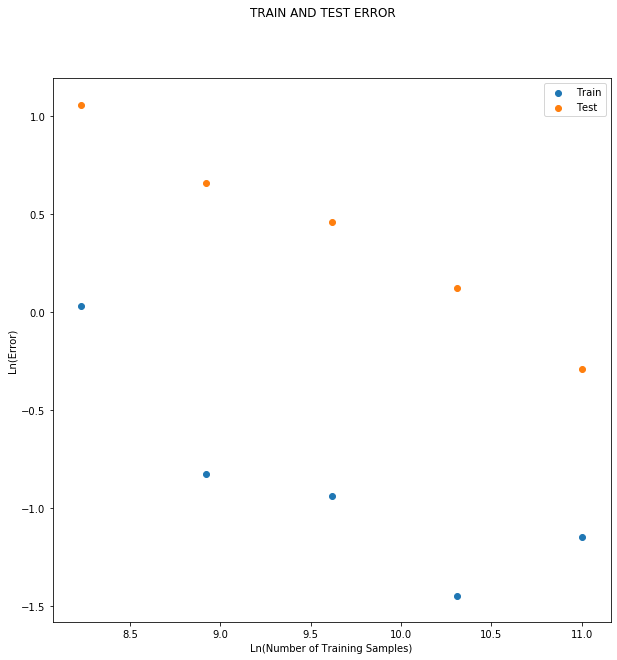

In [10]:
import numpy as np
import matplotlib.pyplot as plt


training_samples = [60000 * element for element in subsets]

def calculate_error(accuracy_values):
    error = []
    for val in accuracy_values:
        error.append(100. - val)
    return error

training_errors = calculate_error(training_errors)
test_errors = calculate_error(test_errors)

fig, axs = plt.subplots(figsize=(10, 10))
plt.scatter(np.log(training_samples), np.log(training_errors), label = "Train")
plt.scatter(np.log(training_samples), np.log(test_errors), label = "Test")

plt.xlabel("Ln(Number of Training Samples)")
plt.ylabel("Ln(Error)")
fig.suptitle("TRAIN AND TEST ERROR")
plt.legend()
plt.savefig("train_and_test_error.png")